In [113]:
import pandas as pd
df1 = pd.read_csv('../../../data/clean/aquifer/auser.csv', index_col=0)
df2 = pd.read_csv('../../../data/clean/aquifer/doganella.csv', index_col=0)
df3 = pd.read_csv('../../../data/clean/aquifer/luco.csv', index_col=0)
df4 = pd.read_csv('../../../data/clean/aquifer/petrignano.csv', index_col=0)
df1.index = pd.to_datetime(df1.index)
df2.index = pd.to_datetime(df2.index)
df3.index = pd.to_datetime(df3.index)
df4.index = pd.to_datetime(df4.index)

In [114]:
df1_rain = df1[[c for c in df1.columns if c.startswith('Rainfall')]]
df2_rain = df2[[c for c in df2.columns if c.startswith('Rainfall')]]
df3_rain = df3[[c for c in df3.columns if c.startswith('Rainfall')]]
df4_rain = df4[[c for c in df4.columns if c.startswith('Rainfall')]]

In [115]:
import matplotlib.pyplot as plt

In [116]:
df1_rain.shape[1], df2_rain.shape[1], df3_rain.shape[1], df4_rain.shape[1]

(10, 2, 7, 1)

In [117]:
df_rain = df1_rain.join(df2_rain).join(df3_rain).join(df4_rain)

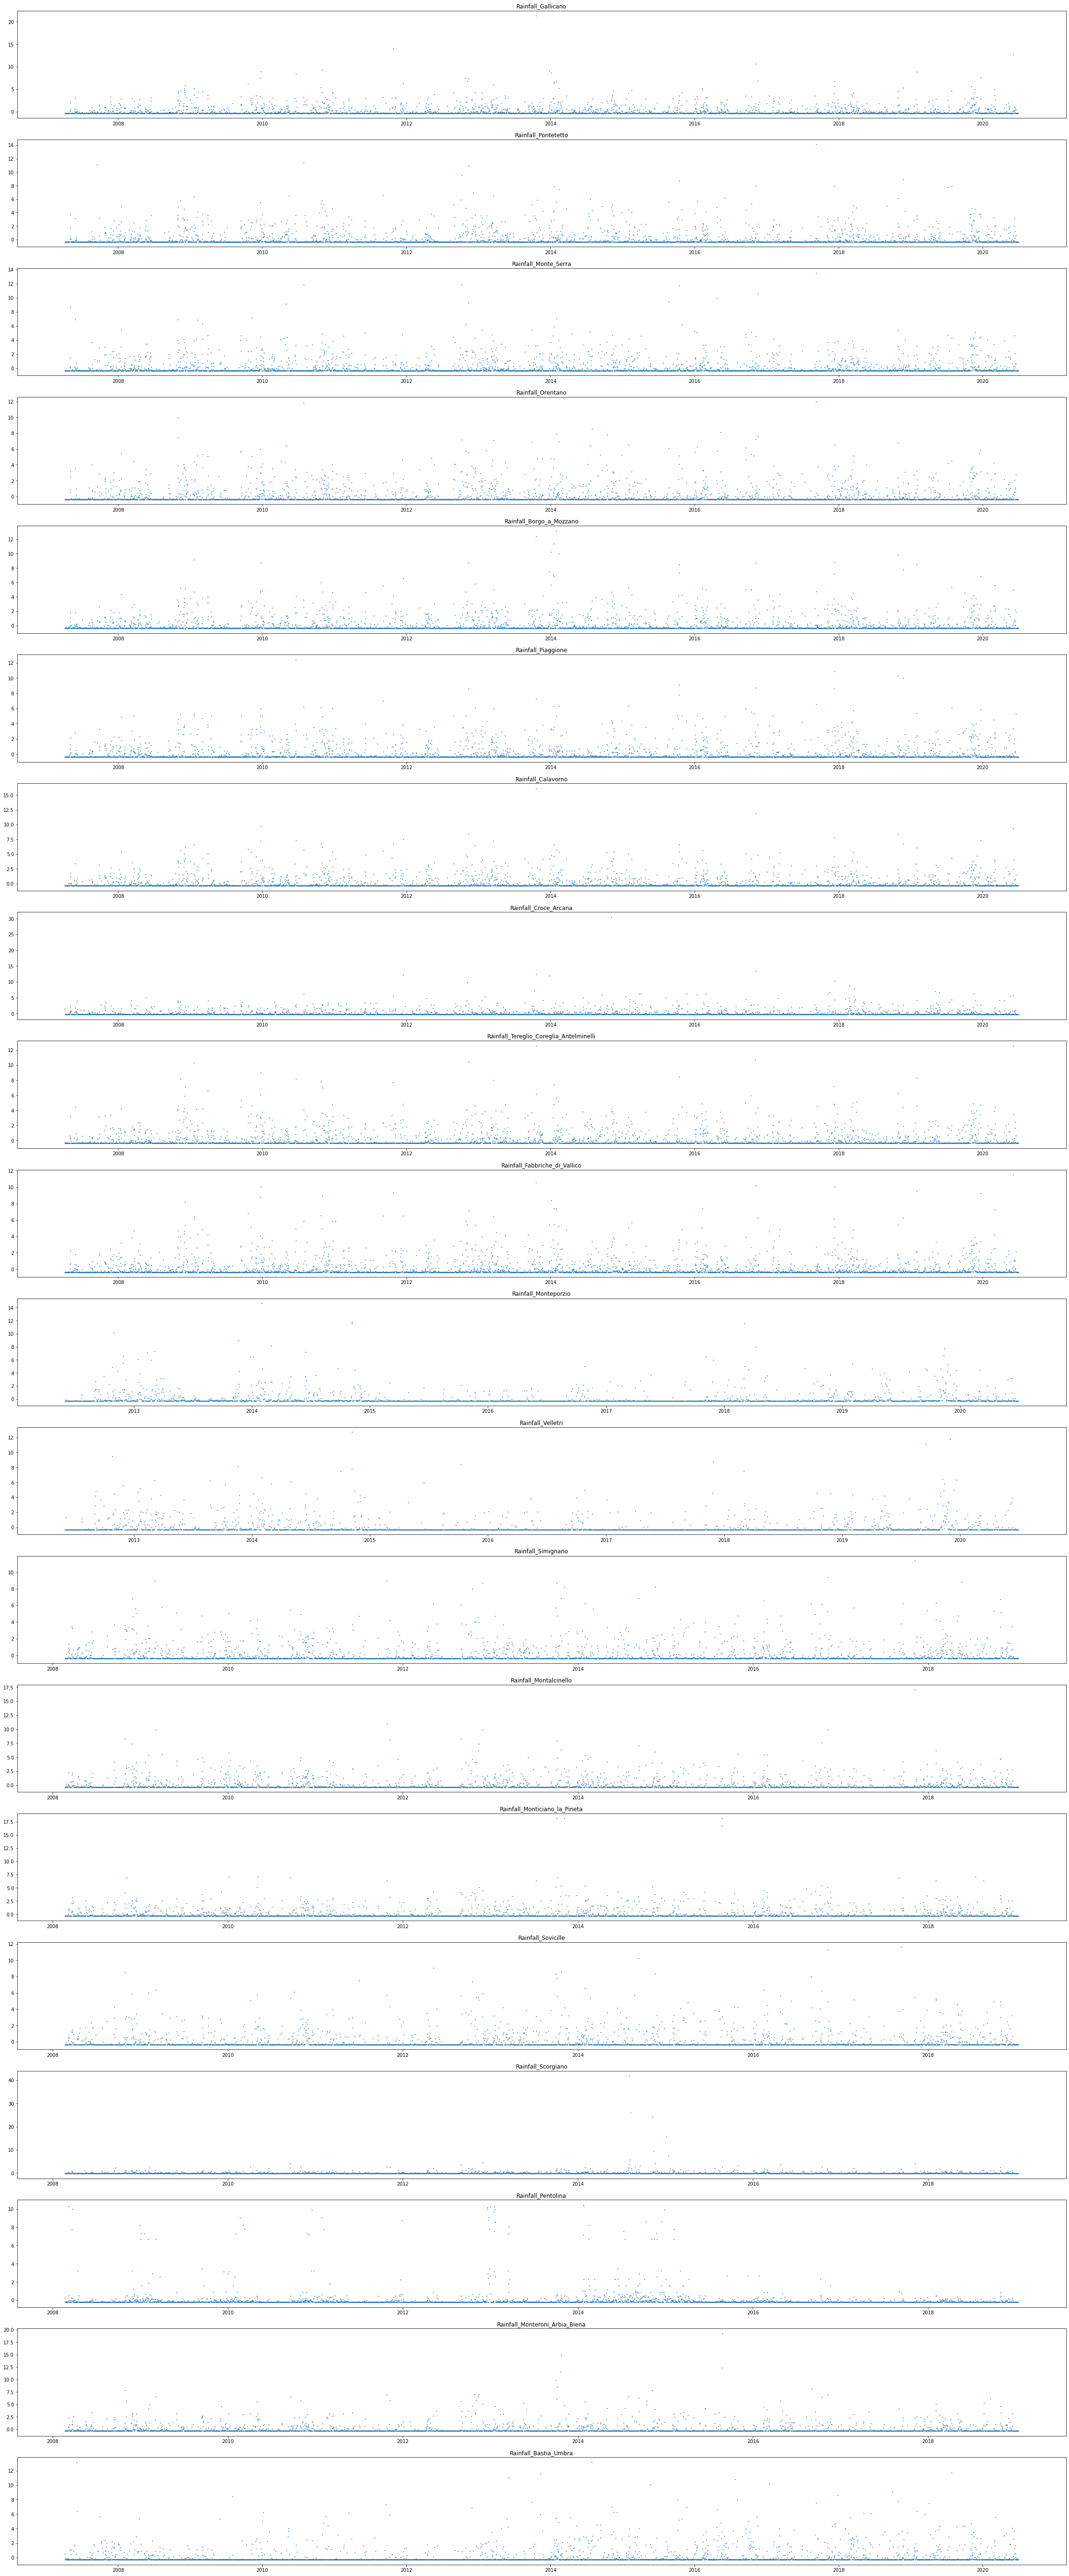

In [118]:
n = len(df_rain.columns)
fig, axs = plt.subplots(n, 1, figsize=(40,5 * n))
for i, c in enumerate(df_rain.columns):
    axs[i].scatter(df_rain.index, df_rain[c], s=1)
    axs[i].set_title(c)
plt.show()

In [146]:
def get_none_ratio(s):
    return len(s[s == s.min()]) / len(s)

def get_outlier_ratio(s):
    return len(s[s > 6 + s.min()]) / len(s)

def get_none_ratios(df):
    rats = {c:get_none_ratio(df[c]) for c in df.columns}
    return pd.Series(rats.values(), index=rats.keys())

def get_outlier_ratios(df):
    rats = {c:get_outlier_ratio(df[c]) for c in df.columns}
    return pd.Series(rats.values(), index=rats.keys())

def get_distribution_ratios(df):
    nones = get_none_ratios(df)
    outs = get_outlier_ratios(df)
    somes = 1 - nones - outs
    return nones, somes, outs

from scipy.stats import sem
def plot_ratios(title, series):
    series = series.sort_values(ascending=False)
    y = series.values
    x = [c.replace('Rainfall_', '') for c in series.index]
    fig, ax = plt.subplots(1, 1, figsize=(12,5))
    plt.xticks(rotation=45, horizontalalignment='right')
    ax.bar(x, y)
    ax.axhline(np.mean(y), c='C3', linestyle=':')
    ax.axhline(np.mean(y) + sem(y, ddof=1), c='C1')
    ax.axhline(np.mean(y) - sem(y, ddof=1), c='C1')
    plt.suptitle(title, fontweight='bold')
    plt.show()

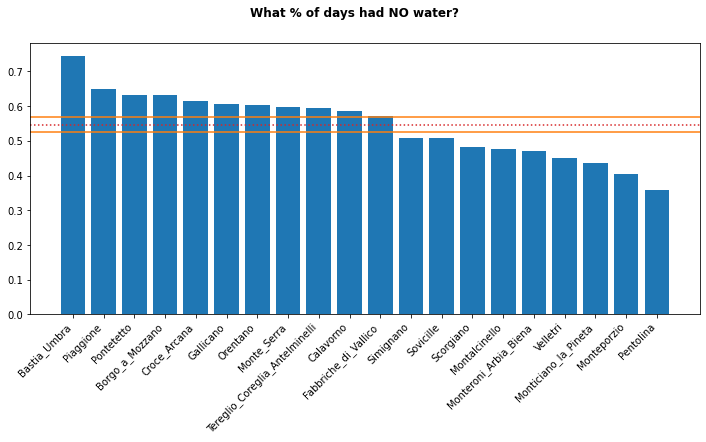

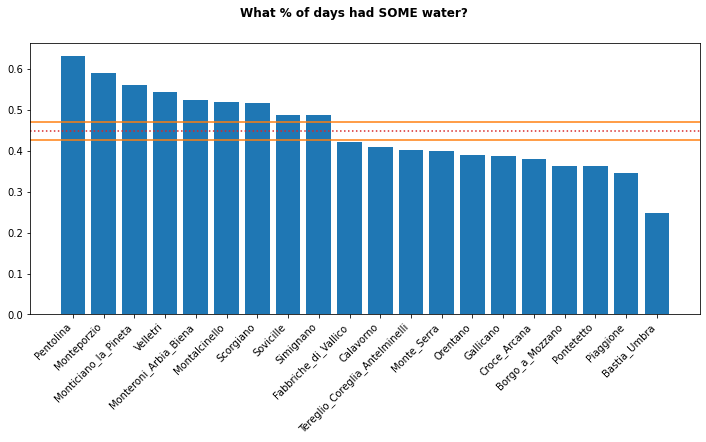

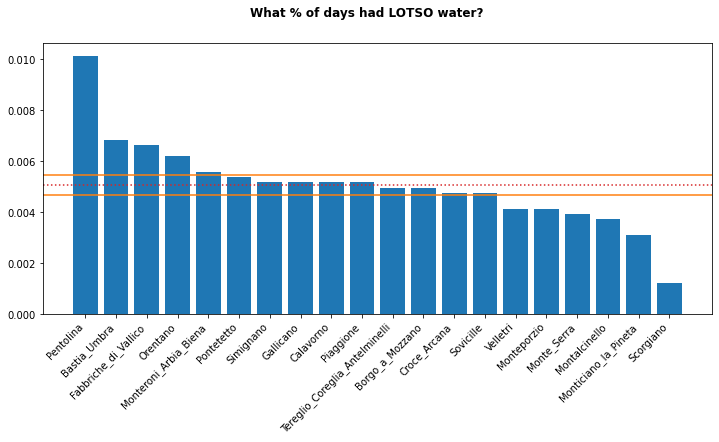

In [147]:
nones, somes, outs = get_distribution_ratios(df_rain)
plot_ratios('What % of days had NO water?', nones)
plot_ratios('What % of days had SOME water?', somes)
plot_ratios('What % of days had LOTSO water?', outs)

In [149]:
cats = {c:[] for c in nones.index}
for c in cats:
    upper = np.mean(nones) + sem(nones, ddof=1)
    lower = np.mean(nones) - sem(nones, ddof=1)
    cat = 'LOW' if nones[c] < lower else 'HIGH' if nones[c] > upper else 'MIDL'
    cats[c].append(cat)
    upper = np.mean(somes) + sem(somes, ddof=1)
    lower = np.mean(somes) - sem(somes, ddof=1)
    cat = 'LOW' if somes[c] < lower else 'HIGH' if somes[c] > upper else 'MIDL'
    cats[c].append(cat)
    upper = np.mean(outs) + sem(outs, ddof=1)
    lower = np.mean(outs) - sem(outs, ddof=1)
    cat = 'LOW' if outs[c] < lower else 'HIGH' if outs[c] > upper else 'MIDL'
    cats[c].append(cat)

In [159]:
df_cats = pd.DataFrame(cats).T
df_cats.columns = ['none', 'some', 'lots']
df_cats['class'] = df_cats['none'] + ',' + df_cats['some'] + ',' + df_cats['lots']
df_cats['class'].value_counts(normalize=True).sort_values(ascending=False)
# "normal" lots of no rain
# "wet" lots of some rain

HIGH,LOW,MIDL    0.35
LOW,HIGH,LOW     0.25
HIGH,LOW,HIGH    0.15
LOW,HIGH,HIGH    0.10
LOW,HIGH,MIDL    0.10
HIGH,LOW,LOW     0.05
Name: class, dtype: float64

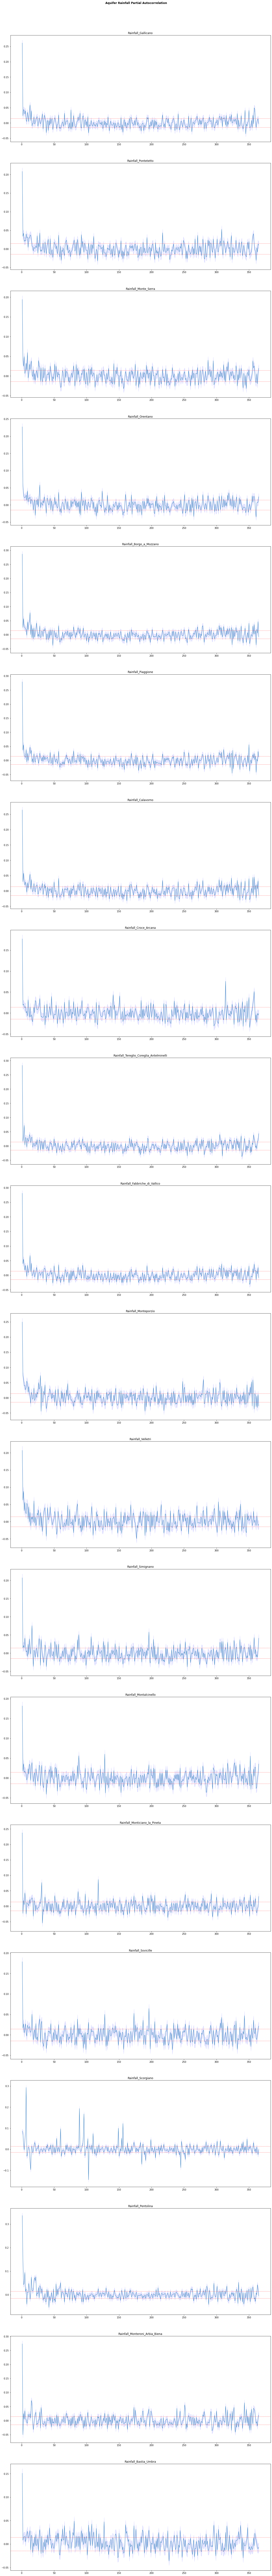

In [99]:
from statsmodels.tsa.stattools import pacf
import warnings
warnings.filterwarnings('ignore')
fig, axs = plt.subplots(20, 1, figsize=(20,200))
fig.suptitle('Aquifer Rainfall Partial Autocorrelation', fontweight='bold', y=.89)
for i, c in enumerate(df_rain.columns):
    pacfs, cints = pacf(df_rain[c].dropna(), nlags=365, alpha=0.5)
    cints[0] = [float('nan'), float('nan')]
    pacfs[0] = float('nan')
#     cints[1] = [float('nan'), float('nan')]
#     pacfs[1] = float('nan')
    axs[i].plot(pacfs, linewidth=1)
    axs[i].fill_between(range(len(pacfs)), [c[0] for c in cints], [c[1] for c in cints], color='b', alpha=0.1)
    axs[i].axhline(1 / df_rain.shape[0] ** 0.5, c='r', linewidth=1, linestyle=':')
    axs[i].axhline(-1 / df_rain.shape[0] ** 0.5, c='r', linewidth=1, linestyle=':')
    axs[i].set_title(c)
plt.show()
# fig, axs = plt.subplots(20, 1, figsize=(20,80))
# fig.suptitle('Aquifer Rainfall Autocorrelation', fontweight='bold', y=.89)
# for i, c in enumerate(df_rain.columns):
#     pd.plotting.autocorrelation_plot(df_rain[c].dropna()[-400:], ax=axs[i])
#     axs[i].set_title(c)
# plt.show()

In [54]:
df_rain.shape

(4835, 20)

In [51]:
df_rain.dtypes

Rainfall_Gallicano                         float64
Rainfall_Pontetetto                        float64
Rainfall_Monte_Serra                       float64
Rainfall_Orentano                          float64
Rainfall_Borgo_a_Mozzano                   float64
Rainfall_Piaggione                         float64
Rainfall_Calavorno                         float64
Rainfall_Croce_Arcana                      float64
Rainfall_Tereglio_Coreglia_Antelminelli    float64
Rainfall_Fabbriche_di_Vallico              float64
Rainfall_Monteporzio                       float64
Rainfall_Velletri                          float64
Rainfall_Simignano                         float64
Rainfall_Montalcinello                     float64
Rainfall_Monticiano_la_Pineta              float64
Rainfall_Sovicille                         float64
Rainfall_Scorgiano                         float64
Rainfall_Pentolina                         float64
Rainfall_Monteroni_Arbia_Biena             float64
Rainfall_Bastia_Umbra          

In [52]:
df_rain['Rainfall_Velletri']

2007-04-06         NaN
2007-04-07         NaN
2007-04-08         NaN
2007-04-09         NaN
2007-04-10         NaN
                ...   
2020-06-26   -0.315073
2020-06-27   -0.315073
2020-06-28   -0.315073
2020-06-29   -0.315073
2020-06-30   -0.315073
Name: Rainfall_Velletri, Length: 4835, dtype: float64

In [102]:
from statsmodels.tsa.stattools import adfuller
print('IS STATIONARY? (ALPHA=0.05)')
for c in df_rain.columns:
    res = adfuller(df_rain[c].dropna())
    print('\t', c, '...', 'YES' if res[0] < res[4]['5%'] else 'NO')

IS STATIONARY? (ALPHA=0.05)
	 Rainfall_Gallicano ... YES
	 Rainfall_Pontetetto ... YES
	 Rainfall_Monte_Serra ... YES
	 Rainfall_Orentano ... YES
	 Rainfall_Borgo_a_Mozzano ... YES
	 Rainfall_Piaggione ... YES
	 Rainfall_Calavorno ... YES
	 Rainfall_Croce_Arcana ... YES
	 Rainfall_Tereglio_Coreglia_Antelminelli ... YES
	 Rainfall_Fabbriche_di_Vallico ... YES
	 Rainfall_Monteporzio ... YES
	 Rainfall_Velletri ... YES
	 Rainfall_Simignano ... YES
	 Rainfall_Montalcinello ... YES
	 Rainfall_Monticiano_la_Pineta ... YES
	 Rainfall_Sovicille ... YES
	 Rainfall_Scorgiano ... YES
	 Rainfall_Pentolina ... YES
	 Rainfall_Monteroni_Arbia_Biena ... YES
	 Rainfall_Bastia_Umbra ... YES


In [103]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

for c in df_rain.columns:
    X = df_rain[c].dropna()
    sent = int(len(X) * 0.66)
    X_train, X_test = X[:sent], X[sent:]
    history = [x for x in X_train]
    predictions = list()
    for t in range(len(X_test)):
        m = ARIMA(history, order=(1,0,0))
        mf = m.fit()
        op = mf.forecast()[0]
        predictions.append(op)
        history.append(X_test[t])
    rmse = mean_squared_error(X_test, predictions, squared=False)
    print(c, '...', rmse)

Rainfall_Gallicano ... 0.9126690121562023
Rainfall_Pontetetto ... 0.979698694421373
Rainfall_Monte_Serra ... 0.9633271997173276
Rainfall_Orentano ... 0.9765001037989417
Rainfall_Borgo_a_Mozzano ... 0.9544260680841151
Rainfall_Piaggione ... 1.0541100586290977
Rainfall_Calavorno ... 0.9493731661265454
Rainfall_Croce_Arcana ... 0.9574097787527732
Rainfall_Tereglio_Coreglia_Antelminelli ... 0.9545936023824845
Rainfall_Fabbriche_di_Vallico ... 0.9600809521616838
Rainfall_Monteporzio ... 1.015454391236391
Rainfall_Velletri ... 1.0455272444215113
Rainfall_Simignano ... 0.9887679455234478
Rainfall_Montalcinello ... 0.9518975900044591
Rainfall_Monticiano_la_Pineta ... 1.013021701202437
Rainfall_Sovicille ... 0.9987327519646553
Rainfall_Scorgiano ... 0.3500790216055914
Rainfall_Pentolina ... 0.24400401193639526
Rainfall_Monteroni_Arbia_Biena ... 0.9700888032152933
Rainfall_Bastia_Umbra ... 1.1567337643182167


In [111]:
from sklearn.metrics import mean_absolute_error
import random
import numpy as np

class ARIMAValidator:
    
    def __init__(self, o):
        self.order = o
    
    def fit(self, X):
        cutoff = int(len(X) * 0.75)
        X_train, X_test = X[:cutoff], X[cutoff:]
        self.history = [x for x in X_train]
        self.predictions = []
        for i in range(len(X_test)):
            m = ARIMA(history, order=self.order)
            mf = m.fit()
            self.predictions.append(mf.forecast()[0])
            self.history.append(X_test[i])
        self.test = X_test
        self.mae = mean_absolute_error(X_test, self.predictions)

class ARIMAGridSearch:
    
    def __init__(self, X):
        self.records = []
        for p in [0,1]:
            for d in [0,1]:
                for q in [0,1]:
                    order = (p,d,q)
                    maes = []
                    for _ in range(5):
                        idx = random.randint(0, len(X) - 366)
                        x = X[idx:idx+365]
                        v = ARIMAValidator(order)
                        v.fit(x)
                        maes.append(v.mae)
                    self.records.append([order, np.mean(maes)])
    
    def best(self):
        maes = [r[1] for r in self.records]
        least = min(maes)
        for o, mae in self.records:
            if mae == least:
                return o

In [112]:
for c in df_rain:
    X = df_rain[c].dropna()
    gs = ARIMAGridSearch(X)
    print(c, '...', gs.best())

Rainfall_Gallicano ... (0, 1, 0)
Rainfall_Pontetetto ... (0, 1, 0)
Rainfall_Monte_Serra ... (1, 1, 0)
Rainfall_Orentano ... (0, 1, 0)
Rainfall_Borgo_a_Mozzano ... (1, 1, 0)
Rainfall_Piaggione ... (0, 1, 0)
Rainfall_Calavorno ... (0, 1, 0)
Rainfall_Croce_Arcana ... (1, 1, 0)
Rainfall_Tereglio_Coreglia_Antelminelli ... (0, 1, 0)
Rainfall_Fabbriche_di_Vallico ... (0, 1, 0)
Rainfall_Monteporzio ... (0, 1, 0)
Rainfall_Velletri ... (1, 1, 0)
Rainfall_Simignano ... (0, 1, 0)
Rainfall_Montalcinello ... (0, 1, 0)
Rainfall_Monticiano_la_Pineta ... (0, 1, 0)
Rainfall_Sovicille ... (1, 1, 0)
Rainfall_Scorgiano ... (1, 0, 0)
Rainfall_Pentolina ... (0, 1, 0)


KeyboardInterrupt: 